In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riped-and-unriped-tomato-dataset/Riped and Unriped Tomato Dataset/labels/riped_tomato_93.txt
/kaggle/input/riped-and-unriped-tomato-dataset/Riped and Unriped Tomato Dataset/labels/riped_tomato_51.txt
/kaggle/input/riped-and-unriped-tomato-dataset/Riped and Unriped Tomato Dataset/labels/unriped_tomato_11.txt
/kaggle/input/riped-and-unriped-tomato-dataset/Riped and Unriped Tomato Dataset/labels/riped_tomato_16.txt
/kaggle/input/riped-and-unriped-tomato-dataset/Riped and Unriped Tomato Dataset/labels/unriped_tomato_45.txt
/kaggle/input/riped-and-unriped-tomato-dataset/Riped and Unriped Tomato Dataset/labels/riped_tomato_96.txt
/kaggle/input/riped-and-unriped-tomato-dataset/Riped and Unriped Tomato Dataset/labels/riped_tomato_91.txt
/kaggle/input/riped-and-unriped-tomato-dataset/Riped and Unriped Tomato Dataset/labels/riped_tomato_90.txt
/kaggle/input/riped-and-unriped-tomato-dataset/Riped and Unriped Tomato Dataset/labels/unriped_tomato_2.txt
/kaggle/input/riped-and-unriped-

In [2]:
from PIL import Image
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [21]:
class TomatoDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpeg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        
        label_name = os.path.join(self.label_dir, self.image_files[idx].replace('.jpeg', '.txt'))
        with open(label_name, 'r') as file:
            lines = file.readlines()
            labels = [line.strip().split() for line in lines]
            class_labels = [int(label[0]) for label in labels]
            label = class_labels[0]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_dir = '/kaggle/input/riped-and-unriped-tomato-dataset/Riped and Unriped Tomato Dataset/Images'
label_dir = '/kaggle/input/riped-and-unriped-tomato-dataset/Riped and Unriped Tomato Dataset/labels'
dataset = TomatoDataset(image_dir, label_dir, transform=transform)

In [22]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [23]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [25]:
num_epochs=25
device='cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
num_epochs = 25
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/25, Loss: 0.8129
Epoch 2/25, Loss: 0.4709
Epoch 3/25, Loss: 0.2722
Epoch 4/25, Loss: 0.2249
Epoch 5/25, Loss: 0.1740
Epoch 6/25, Loss: 0.1283
Epoch 7/25, Loss: 0.1122
Epoch 8/25, Loss: 0.0765
Epoch 9/25, Loss: 0.0640
Epoch 10/25, Loss: 0.0690
Epoch 11/25, Loss: 0.0693
Epoch 12/25, Loss: 0.0694
Epoch 13/25, Loss: 0.0651
Epoch 14/25, Loss: 0.0533
Epoch 15/25, Loss: 0.0557
Epoch 16/25, Loss: 0.0772
Epoch 17/25, Loss: 0.0787
Epoch 18/25, Loss: 0.1098
Epoch 19/25, Loss: 0.0661
Epoch 20/25, Loss: 0.0553
Epoch 21/25, Loss: 0.0741
Epoch 22/25, Loss: 0.0628
Epoch 23/25, Loss: 0.0565
Epoch 24/25, Loss: 0.0476
Epoch 25/25, Loss: 0.0607


In [29]:
model.eval()
correct=0
total=0

with torch.no_grad():
    for inputs,labels in val_loader:
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=model(inputs)
        _,predicted=torch.max(outputs,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
        
accuracy=100*correct/total
print(f'Validation Accuracy:{accuracy:.2f}%')
        
        
        

Validation Accuracy:91.67%


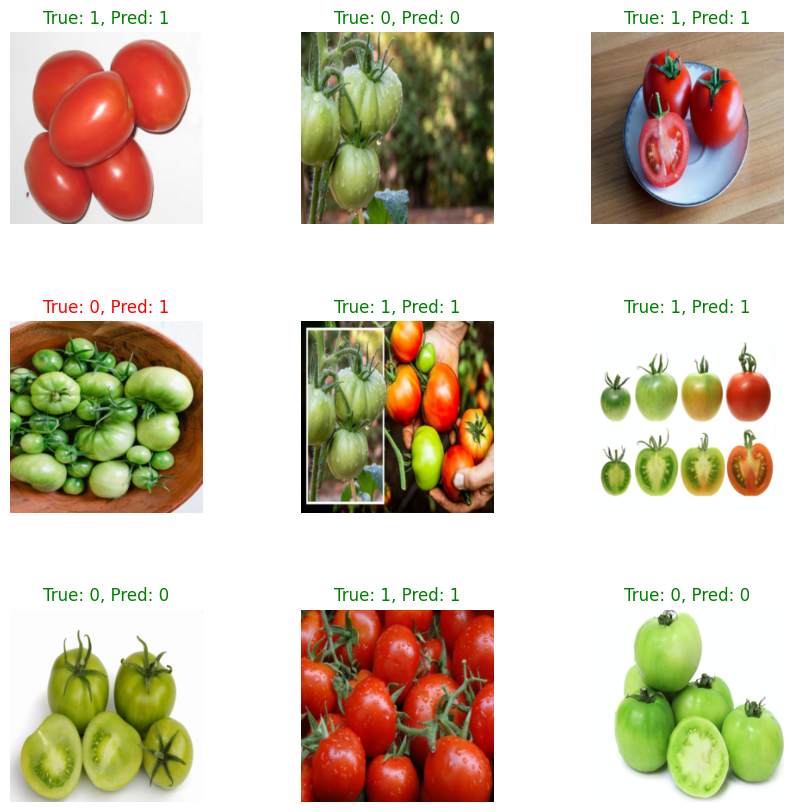

In [30]:
import random
import matplotlib.pyplot as plt

model.eval()

val_images = []
val_labels = []
val_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        val_images.extend(inputs.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())
        val_preds.extend(preds.cpu().numpy())

val_images = np.array(val_images)
val_labels = np.array(val_labels)
val_preds = np.array(val_preds)

indices = random.sample(range(len(val_images)), 9)
sample_images = val_images[indices]
sample_labels = val_labels[indices]
sample_preds = val_preds[indices]

def imshow(image, ax):
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.axis('off')

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, ax in enumerate(axes.flat):
    img = sample_images[i]
    true_label = sample_labels[i]
    pred_label = sample_preds[i]
    color = 'green' if true_label == pred_label else 'red'
    title = f'True: {true_label}, Pred: {pred_label}'
    ax.set_title(title, color=color)
    imshow(img, ax)

plt.show()